In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import string
from nltk.tokenize import word_tokenize
from torch.optim import lr_scheduler
from transformers import BertConfig, BertForPreTraining
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import NFKC
from torch.utils.tensorboard import SummaryWriter

In [2]:
#splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet('./0000.parquet')
df.head()

,id,text,label
0,3614,"EXAM: , CT scan of the abdomen and pelvis with...",23
1,488,"PREOPERATIVE DIAGNOSIS: , Fracture dislocation...",25
2,2482,"EARS, NOSE, MOUTH AND THROAT,EARS/NOSE: , The ...",32
3,3552,"PREOPERATIVE DIAGNOSIS: , Refractory dyspepsia...",23
4,3437,"CHIEF COMPLAINT:, Lump in the chest wall.,HIS...",36


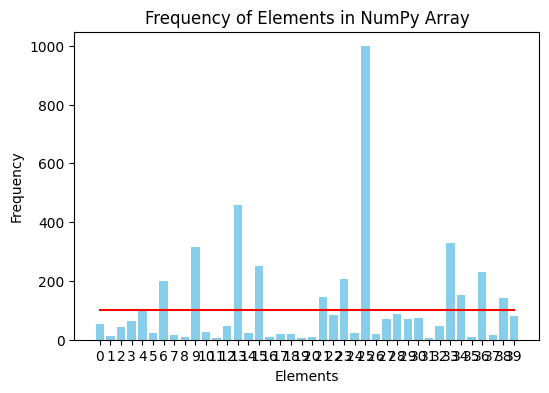

In [3]:
array = df.to_numpy()[:,2]

counter = Counter(array)
elements = list(counter.keys())
frequencies = list(counter.values())


plt.figure(figsize=(6, 4))
plt.bar(elements, frequencies, color='skyblue')
plt.plot([0,39],[100,100],c='r')
plt.xlabel('Elements')
plt.ylabel('Frequency')
plt.title('Frequency of Elements in NumPy Array')
plt.xticks(elements)
plt.show()

In [4]:
filtered_elements = {element: count for element, count in counter.items() if count > 100}
dataa = df.to_numpy()
data = dataa[np.isin(dataa[:,2].copy(), list(filtered_elements.keys()))].copy()
filter_target = np.array(list(filtered_elements.keys()))
print(len(filter_target))
for i in range(len(data)):
    real_target = data[i,2]
    new_target = np.argwhere(real_target == filter_target)[0][0]
    data[i,2] = new_target
print(np.unique(data[:,2]))
print(data.shape)

11
[0 1 2 3 4 5 6 7 8 9 10]
(3429, 3)


In [5]:
nltk.download('punkt')

def clean_text(text):
    words = word_tokenize(text.lower())
    cleaned_words = [word for word in words if word not in string.punctuation]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

for i in range(len(data)):
    data[i,1] = clean_text(data[i,1])
    
pd.DataFrame(data).head()

[nltk_data] Downloading package punkt to /home/ali_kz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,0,1,2
0,3614,exam ct scan of the abdomen and pelvis without...,0
1,488,preoperative diagnosis fracture dislocation c2...,1
2,3552,preoperative diagnosis refractory dyspepsia. p...,0
3,3437,chief complaint lump in the chest wall. histor...,2
4,736,preoperative diagnosis subcapital left hip fra...,1


In [6]:
targets = (data[:,2].astype(np.int32).copy()) # 11 class
path = "./file.txt"
with open(path, 'w') as file:
    for string in data[:,1]:
        file.write(string + " ")

tokenizer = Tokenizer(BPE())
tokenizer.normalizer = NFKC()
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(
    vocab_size=15000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

files = ["./file.txt"]
tokenizer.train(files, trainer)

tokenizer.save("./tokenizer.json")

In [7]:
def tokenize(data):
    tokenized_list = []
    for text in data[:,1]:
        encoded_ids = tokenizer.encode(text).ids
        tokenized_list.append(encoded_ids)
    return tokenized_list
tokenized_list = tokenize(data)
len_tokeniz = np.array([len(i) for i in (tokenized_list)])
print(data.shape)
data = data[len_tokeniz > 100]
print(data.shape)
tokenized_list = tokenize(data)
len_tokeniz = np.array([len(i) for i in (tokenized_list)])
print(f'max length = {np.max(len_tokeniz)}, min length = {np.min(len_tokeniz)}')

(3429, 3)
(3330, 3)
max length = 2813, min length = 101


In [8]:
class PreTrainDataSet(Dataset):
    def __init__(self, data_tokens, targets):
        self.data_tokens = data_tokens
        self.targets = torch.tensor(list(targets)).type(torch.LongTensor)

    def __len__(self):
        return len(self.data_tokens)

    def __getitem__(self, idx):
        description = self.data_tokens[idx]
        non_zero_count = torch.nonzero(description).size(0)
        ret_tokens1 = torch.full((256,), 2)  # 2 for [CLS]
        if non_zero_count < 256:
            ret_tokens1[1:] = description[:255]
        else:
            start_idx = torch.randint(high = non_zero_count - 255,size=(1,)).item()
            ret_tokens1[1:] = description[start_idx:start_idx+255]
        
        
        is_similar = torch.randint(2,(1,)).item()
        if is_similar == 1:  # 1 for not_similar
            unsimilar_tokens = (torch.argwhere(self.targets != self.targets[idx])[:,0])
            random_index = unsimilar_tokens[torch.randint(unsimilar_tokens.shape[0],(1,)).item()]
        else:                # 0 for similar
            similar_tokens = (torch.argwhere(self.targets == self.targets[idx])[:,0])
            random_index = similar_tokens[torch.randint(similar_tokens.shape[0],(1,)).item()]
 
        description = self.data_tokens[random_index]
        non_zero_count = torch.nonzero(description).size(0)
        ret_tokens2 = torch.full((256,), 3) # 3 for [SEP]
        if non_zero_count < 256:
            ret_tokens2[1:] = description[:255]
        else:
            start_idx = torch.randint(high = non_zero_count - 255,size=(1,)).item()
            ret_tokens2[1:] = description[start_idx:start_idx+255]
        
        ret_tokens = torch.cat((ret_tokens1,ret_tokens2))
        
        non_zero_indices = torch.nonzero(ret_tokens)[:,0]
        shuffled_indices = non_zero_indices[torch.randperm(non_zero_indices.size(0))]
        random_indices = shuffled_indices[:int(shuffled_indices.size(0) * 0.15)]
        
        masked_labels = torch.full((512,),-100)
        masked_labels[random_indices] = ret_tokens[random_indices]
        ret_tokens[random_indices] = 4 # [MASK]
        return ret_tokens, masked_labels, is_similar

max_len = np.max(len_tokeniz)
token_padded = [torch.cat((torch.tensor(inner_list,dtype=torch.int32),torch.zeros(max_len - len(inner_list),dtype=torch.int32))).unsqueeze(0) for inner_list in tokenized_list]
data_tokens = torch.cat(token_padded)
print(data_tokens.shape)

random_indices_for_split =  torch.load('./shuffle.pt')
torch.save(random_indices_for_split,'shuffle.pt')
train_size = int(0.85 * data_tokens.shape[0])
train_pretrain_indices , test_pretrain_indices = random_indices_for_split[:train_size], random_indices_for_split[train_size:]

pretrain_train_dataset = PreTrainDataSet(data_tokens[train_pretrain_indices], data[train_pretrain_indices,2])
pretrain_test_dataset = PreTrainDataSet(data_tokens[test_pretrain_indices], data[test_pretrain_indices,2])

pretrain_train_loader = DataLoader(pretrain_train_dataset,batch_size=32,shuffle=True)
pretrain_test_loader = DataLoader(pretrain_test_dataset,batch_size=32,shuffle=False)

print(f'len train {len(pretrain_train_dataset)} and len test {len(pretrain_test_dataset)}')

torch.Size([3330, 2813])
len train 2830 and len test 500


In [12]:
for tokens_b, MLM_labels_b, is_similar_b in (pretrain_train_loader):
    print(tokenizer.decode(list(tokens_b[0]),False))
    print(is_similar_b[0])
    print(tokenizer.decode(list(tokens_b[1]),False))
    print(is_similar_b[1])
    break

[CLS] much better [MASK] since that time he has been in [MASK] [MASK] with minimal pain [MASK] [MASK] [MASK] no numbness tingling or other concerning symptoms [MASK] past medical [MASK] [MASK] . social history the patient is a nonsmoker and does not use illegal [MASK] occasionally [MASK] . review of systems a 12 - point review of [MASK] is negative . medications none . allergies no known drug allergies . findings on physical exam he has swelling and tenderness over the ulnar dorsum [MASK] his hand he has a normal c asc [MASK] [MASK] has 70 [MASK] of mcp [MASK] and full ip flexion and [MASK] he has 3 to 5 strength in his [MASK] and intrins ics he has intact sensation to light touch in the radial ulnar and median nerve distribution two [MASK] radial pulse . x - rays taken from today were [MASK] include three views of the right hand they show possible small fractures of [MASK] base of the fourth and third metacarpals joint [MASK] to be located [MASK] 45 - degree oblique view was obtained 

In [27]:
def loss_fn(batch_size,criterion,prediction_logits,seq_relationship_logits,MLM_labels_b, is_similar_b):
    loss_MLM = 0
    for j, batch_labels in enumerate(MLM_labels_b):
        loss_indices = torch.argwhere(batch_labels != -100).reshape(-1,)
        loss_labels = batch_labels[loss_indices]
        loss_score = prediction_logits[j,loss_indices,:]
        predicted = torch.argmax(loss_score,dim=1)
        all_prediction_MLM.append(predicted) , all_lables_MLM.append(loss_labels)
        loss_MLM += criterion(loss_score, loss_labels)
    loss_MLM /= batch_size
    
    loss_NSP = criterion(seq_relationship_logits,is_similar_b)
    predicted = torch.argmax(seq_relationship_logits,dim=1)
    all_prediction_NSP.append(predicted) , all_lables_NSP.append(is_similar_b)
    return loss_NSP , loss_MLM
   
device = torch.device('cuda')

configuration = BertConfig(vocab_size=15000,hidden_size = 64,num_hidden_layers = 3,num_attention_heads = 4,intermediate_size = 512,hidden_dropout_prob=0.2)
bert_pretraining = BertForPreTraining(configuration).to(device)
total_params = sum(p.numel() for p in bert_pretraining.parameters())
print(f'Total number of parameters: {total_params}')

num_epochs = 200

optimizer = optim.AdamW(bert_pretraining.parameters(), lr=1e-3,weight_decay=1e-1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=5,factor=0.5,verbose=True)
criterion = nn.CrossEntropyLoss()
loss_MLM_train, loss_NSP_train, acc_MLM_train, acc_NSP_train = [], [] ,[], []
loss_MLM_test, loss_NSP_test, acc_MLM_test, acc_NSP_test = [], [] ,[], []

for epoch in range(num_epochs):
    bert_pretraining.train()
    running_loss, running_MLM, running_NSP  = 0.0, 0.0 , 0.0 
    all_prediction_MLM , all_lables_MLM, all_prediction_NSP , all_lables_NSP = [], [], [], []
    for i, (tokens_b, MLM_labels_b, is_similar_b) in enumerate(pretrain_train_loader):
        batch_size = tokens_b.shape[0]
        tokens_b, MLM_labels_b, is_similar_b = tokens_b.to(device), MLM_labels_b.to(device), is_similar_b.to(device)
        token_type_ids = torch.zeros(batch_size,512).to(device=device,dtype=torch.int64)
        token_type_ids[:,256:] = 1
        attention_mask = (tokens_b != 0 ).type(torch.FloatTensor).to(device=device)
        output = bert_pretraining(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device),labels=MLM_labels_b,next_sentence_label=is_similar_b)
        prediction_logits = output.prediction_logits # b, 512, 15000
        seq_relationship_logits = output.seq_relationship_logits # b,2
        loss_NSP , loss_MLM = loss_fn(batch_size,criterion,prediction_logits,seq_relationship_logits,MLM_labels_b, is_similar_b)
        loss = loss_NSP + loss_MLM
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_MLM += loss_MLM.item()
        running_NSP += loss_NSP.item()
    scheduler.step(running_loss)
    all_prediction_MLM_cat = torch.cat(all_prediction_MLM).cpu()
    all_lables_MLM_cat = torch.cat(all_lables_MLM).cpu()
    acc_MLM = accuracy_score(all_prediction_MLM_cat, all_lables_MLM_cat)
    all_prediction_NSP_cat = torch.cat(all_prediction_NSP).cpu()
    all_lables_NSP_cat = torch.cat(all_lables_NSP).cpu()
    acc_NSP = accuracy_score(all_prediction_NSP_cat, all_lables_NSP_cat)
    if (epoch + 1) % 10 == 0: 
        print(f'epoch {epoch + 1} : Train MLM_loss {running_MLM / (i + 1):.4f} NSP_loss {running_NSP / (i + 1):.4f} MLM_acc {acc_MLM:.3f} NSP_acc {acc_NSP:.3f}', end='')
    loss_MLM_train.append(running_MLM / (i + 1)), loss_NSP_train.append(running_NSP / (i + 1)), acc_MLM_train.append(acc_MLM), acc_NSP_train.append(acc_NSP)
    
    bert_pretraining.eval()
    running_loss, running_MLM, running_NSP  = 0.0, 0.0 , 0.0 
    all_prediction_MLM , all_lables_MLM, all_prediction_NSP , all_lables_NSP = [], [], [], []
    with torch.no_grad():
        for i, (tokens_b, MLM_labels_b, is_similar_b) in enumerate(pretrain_test_loader):
            batch_size = tokens_b.shape[0]
            tokens_b, MLM_labels_b, is_similar_b = tokens_b.to(device), MLM_labels_b.to(device), is_similar_b.to(device)
            token_type_ids = torch.zeros(batch_size,512).to(device=device,dtype=torch.int64)
            token_type_ids[:,256:] = 1
            attention_mask = (tokens_b != 0 ).type(torch.FloatTensor).to(device=device)
            output = bert_pretraining(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device),labels=MLM_labels_b,next_sentence_label=is_similar_b)
            prediction_logits = output.prediction_logits # b, 512, 15000
            seq_relationship_logits = output.seq_relationship_logits # b,2
            loss_NSP , loss_MLM = loss_fn(batch_size,criterion,prediction_logits,seq_relationship_logits,MLM_labels_b, is_similar_b)
            loss = loss_NSP + loss_MLM
            running_loss += loss.item()
            running_MLM += loss_MLM.item()
            running_NSP += loss_NSP.item()
    all_prediction_MLM_cat = torch.cat(all_prediction_MLM).cpu()
    all_lables_MLM_cat = torch.cat(all_lables_MLM).cpu()
    acc_MLM = accuracy_score(all_prediction_MLM_cat, all_lables_MLM_cat)
    all_prediction_NSP_cat = torch.cat(all_prediction_NSP).cpu()
    all_lables_NSP_cat = torch.cat(all_lables_NSP).cpu()
    acc_NSP = accuracy_score(all_prediction_NSP_cat, all_lables_NSP_cat)
    if (epoch + 1) % 10 == 0:
        print(f' -- TEST MLM_loss {running_MLM / (i + 1):.4f} NSP_loss {running_NSP / (i + 1):.4f} MLM_acc {acc_MLM:.3f} NSP_acc {acc_NSP:.3f}')
    loss_MLM_test.append(running_MLM / (i + 1)), loss_NSP_test.append(running_NSP / (i + 1)), acc_MLM_test.append(acc_MLM), acc_NSP_test.append(acc_NSP)
bert_pretraining.save_pretrained('/kaggle/working/bert_pretrain')

Total number of parameters: 1265626


/usr/local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


KeyboardInterrupt: 

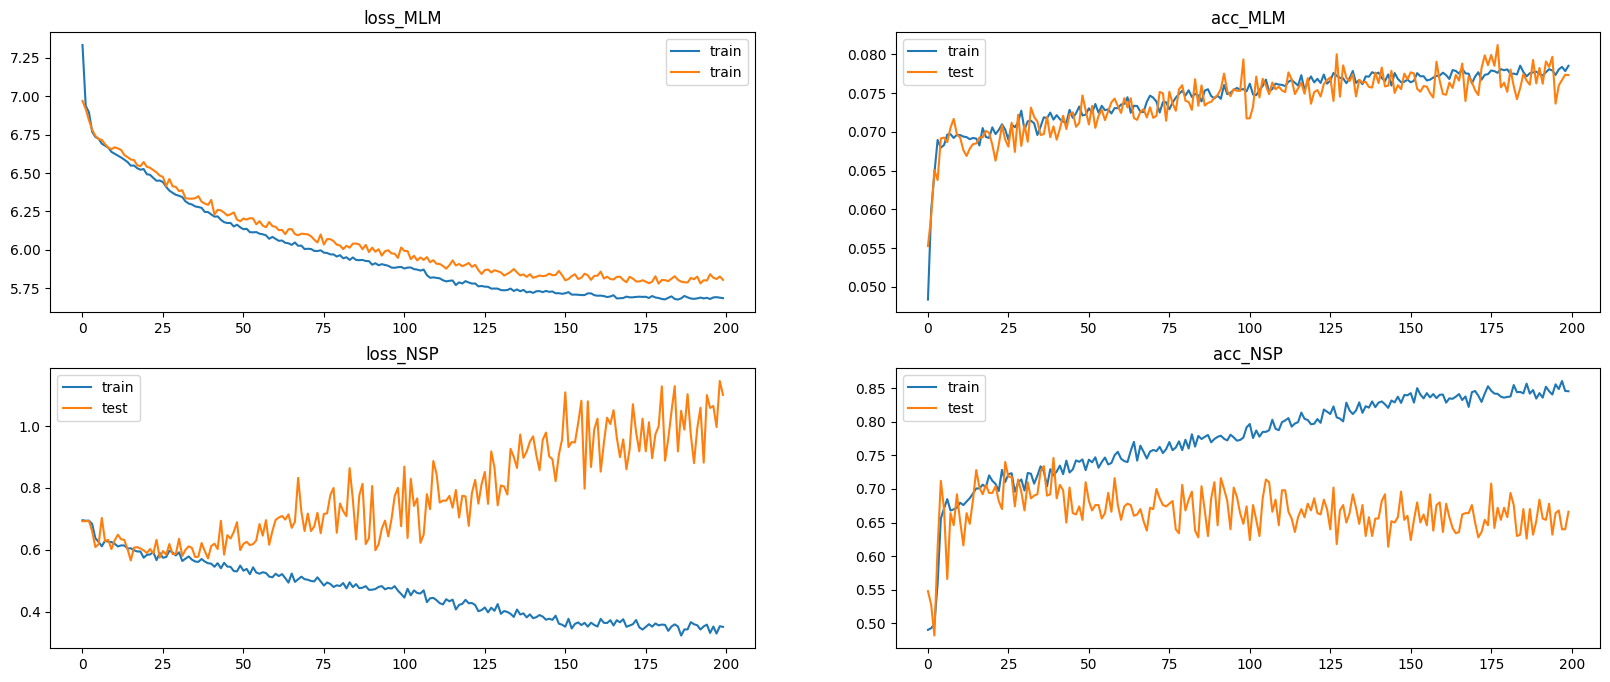

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.plot(loss_MLM_train,label='train')
plt.plot(loss_MLM_test,label='train')
plt.title('loss_MLM')
plt.legend()
plt.subplot(2,2,2)
plt.plot(acc_MLM_train,label='train')
plt.plot(acc_MLM_test,label='test')
plt.title('acc_MLM')
plt.legend()
plt.subplot(2,2,3)
plt.plot(loss_NSP_train,label='train')
plt.plot(loss_NSP_test,label='test')
plt.title('loss_NSP')
plt.legend()
plt.subplot(2,2,4)
plt.plot(acc_NSP_train,label='train')
plt.plot(acc_NSP_test,label='test')
plt.title('acc_NSP')
plt.legend()
plt.show()

In [9]:
class FineTuneDataSet(Dataset):
    def __init__(self, data_tokens, targets):
        self.data_tokens = data_tokens
        self.targets = torch.tensor(list(targets)).type(torch.LongTensor)

    def __len__(self):
        return len(self.data_tokens)

    def __getitem__(self, idx):
        description = self.data_tokens[idx]
        non_zero_count = torch.nonzero(description).size(0)
        ret_tokens = torch.full((512,), 2)  # 2 for [CLS]
        if non_zero_count < 512:
            ret_tokens[1:] = description[:511]
        else:
            start_idx = torch.randint(high = non_zero_count - 511,size=(1,)).item()
            ret_tokens[1:] = description[start_idx:start_idx+511]
        return ret_tokens, self.targets[idx]


random_indices_for_split =  torch.load('./shuffle.pt')
train_size = int(0.85 * data_tokens.shape[0])
train_pretrain_indices , test_pretrain_indices = random_indices_for_split[:train_size], random_indices_for_split[train_size:]

finetune_train_dataset = FineTuneDataSet(data_tokens[train_pretrain_indices], data[train_pretrain_indices,2])
finetune_test_dataset = FineTuneDataSet(data_tokens[test_pretrain_indices], data[test_pretrain_indices,2])

finetune_train_loader = DataLoader(finetune_train_dataset,batch_size=32,shuffle=True)
finetune_test_loader = DataLoader(finetune_test_dataset,batch_size=32,shuffle=False)

print(f'len train {len(pretrain_train_dataset)} and len test {len(pretrain_test_dataset)}')

len train 2830 and len test 500


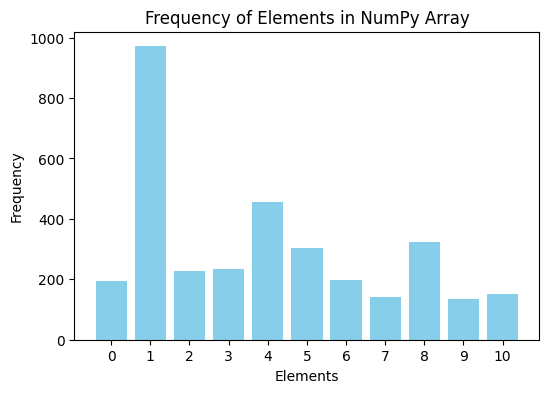

tensor([0.1038, 0.0207, 0.0883, 0.0861, 0.0443, 0.0667, 0.1022, 0.1408, 0.0625,
        0.1503, 0.1343])

In [10]:
array = data[:,2].copy()

counter = Counter(array)
elements = list(counter.keys())
frequencies = list(counter.values())


plt.figure(figsize=(6, 4))
plt.bar(elements, frequencies, color='skyblue')
plt.xlabel('Elements')
plt.ylabel('Frequency')
plt.title('Frequency of Elements in NumPy Array')
plt.xticks(elements)
plt.show()
class_weights = 1 / torch.tensor(frequencies)
class_weights /= class_weights.sum()
class_weights

In [11]:
class CustomBert(nn.Module):
    def __init__(self, BertPreTrainModel):
        super(CustomBert, self).__init__()
        self.BertPreTrainModel = BertPreTrainModel
        self.fc = nn.Sequential(
            nn.Linear(BertPreTrainModel.config.hidden_size,48),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(48,24),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(24,11)
        )
        
    def forward(self,input_ids,attention_mask,token_type_ids,position_ids):
        out = self.BertPreTrainModel(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=position_ids)
        cls_state = out.hidden_states[-1][:,0,:] # batch, 512, 64 select CLS
        return self.fc(cls_state)

In [47]:
device = torch.device('cuda')

BertPreTrainModel = BertForPreTraining.from_pretrained('/kaggle/input/pretrainbert/pytorch/default/1').to(device)
BertPreTrainModel.config.output_hidden_states = True
Bert = CustomBert(BertPreTrainModel).to(device)

num_epochs = 130

optimizer = optim.AdamW([
    {'params': Bert.BertPreTrainModel.parameters(), 'lr': 2e-5, 'weight_decay':0.25}, # bigger lr cause fast acc but overfit
    {'params': Bert.fc.parameters(), 'lr': 1e-3, 'weight_decay':0.25}])
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
scheduler = lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.8)

train_loss_list, train_acc_list, train_f1_list = [], [], []
test_loss_list, test_acc_list, test_f1_list = [], [], []

for epoch in range(num_epochs):
    Bert.train()
    running_loss  = 0.0
    all_prediction , all_lables = [], []
    for i, (tokens_b, labels) in enumerate(finetune_train_loader):
        tokens_b, labels = tokens_b.to(device), labels.to(device)
        batch_size = tokens_b.shape[0]
        token_type_ids = torch.zeros(batch_size,512).to(device=device, dtype=torch.int32)
        token_type_ids[:,256:] = 1
        attention_mask = (tokens_b != 0 ).to(dtype=torch.int32,device=device)
        outputs = Bert(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device))
        predicted = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        all_prediction.append(predicted) , all_lables.append(labels) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    all_prediction_cat = torch.cat(all_prediction).cpu()
    all_lables_cat = torch.cat(all_lables).cpu()
    acc = accuracy_score(all_lables_cat, all_prediction_cat)
    f1 = f1_score(all_lables_cat, all_prediction_cat,average='macro')
    if (epoch + 1) % 10 == 0:
        print(f'epoch {epoch+1} Train loss {running_loss / (i+1):.4f} and accuracy {acc:.3f} f1 {f1:.3f}', end='')
    train_loss_list.append(running_loss / (i+1)), train_acc_list.append(acc), train_f1_list.append(f1)
    
    Bert.eval()
    running_loss  = 0.0
    all_prediction , all_lables = [], []
    with torch.no_grad():
        for i, (tokens_b, labels) in enumerate(finetune_test_loader):
            labels = labels.type(torch.LongTensor) 
            tokens_b, labels = tokens_b.to(device), labels.to(device)
            batch_size = tokens_b.shape[0]
            token_type_ids = torch.zeros(batch_size,512).to(device=device, dtype=torch.int32)
            token_type_ids[:,256:] = 1
            attention_mask = (tokens_b != 0 ).to(dtype=torch.int32,device=device)
            outputs = Bert(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device))
            predicted = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            all_prediction.append(predicted) , all_lables.append(labels) 
            running_loss += loss.item()
    all_prediction_cat = torch.cat(all_prediction).cpu()
    all_lables_cat = torch.cat(all_lables).cpu()
    acc = accuracy_score(all_lables_cat, all_prediction_cat)
    f1 = f1_score(all_lables_cat, all_prediction_cat,average='macro')
    if (epoch + 1) % 10 == 0:
        print(f' -- Test loss {running_loss / (i+1):.4f} and accuracy {acc:.3f} f1 {f1:.3f}')
    test_loss_list.append(running_loss / (i+1)), test_acc_list.append(acc), test_f1_list.append(f1)

epoch 10 Train loss 0.9258 and accuracy 0.632 f1 0.600 -- Test loss 1.9444 and accuracy 0.434 f1 0.425
epoch 20 Train loss 0.8113 and accuracy 0.661 f1 0.642 -- Test loss 1.9378 and accuracy 0.454 f1 0.456
epoch 30 Train loss 0.7463 and accuracy 0.681 f1 0.669 -- Test loss 2.0948 and accuracy 0.474 f1 0.482
epoch 40 Train loss 0.6814 and accuracy 0.697 f1 0.688 -- Test loss 2.1107 and accuracy 0.460 f1 0.466
epoch 50 Train loss 0.6486 and accuracy 0.710 f1 0.707 -- Test loss 2.2256 and accuracy 0.476 f1 0.479
epoch 60 Train loss 0.6512 and accuracy 0.712 f1 0.708 -- Test loss 2.1269 and accuracy 0.472 f1 0.479
epoch 70 Train loss 0.6316 and accuracy 0.713 f1 0.708 -- Test loss 2.3077 and accuracy 0.484 f1 0.489
epoch 80 Train loss 0.6234 and accuracy 0.722 f1 0.719 -- Test loss 2.3172 and accuracy 0.462 f1 0.467
epoch 90 Train loss 0.6286 and accuracy 0.718 f1 0.716 -- Test loss 2.1933 and accuracy 0.486 f1 0.499
epoch 100 Train loss 0.6137 and accuracy 0.730 f1 0.729 -- Test loss 2.39

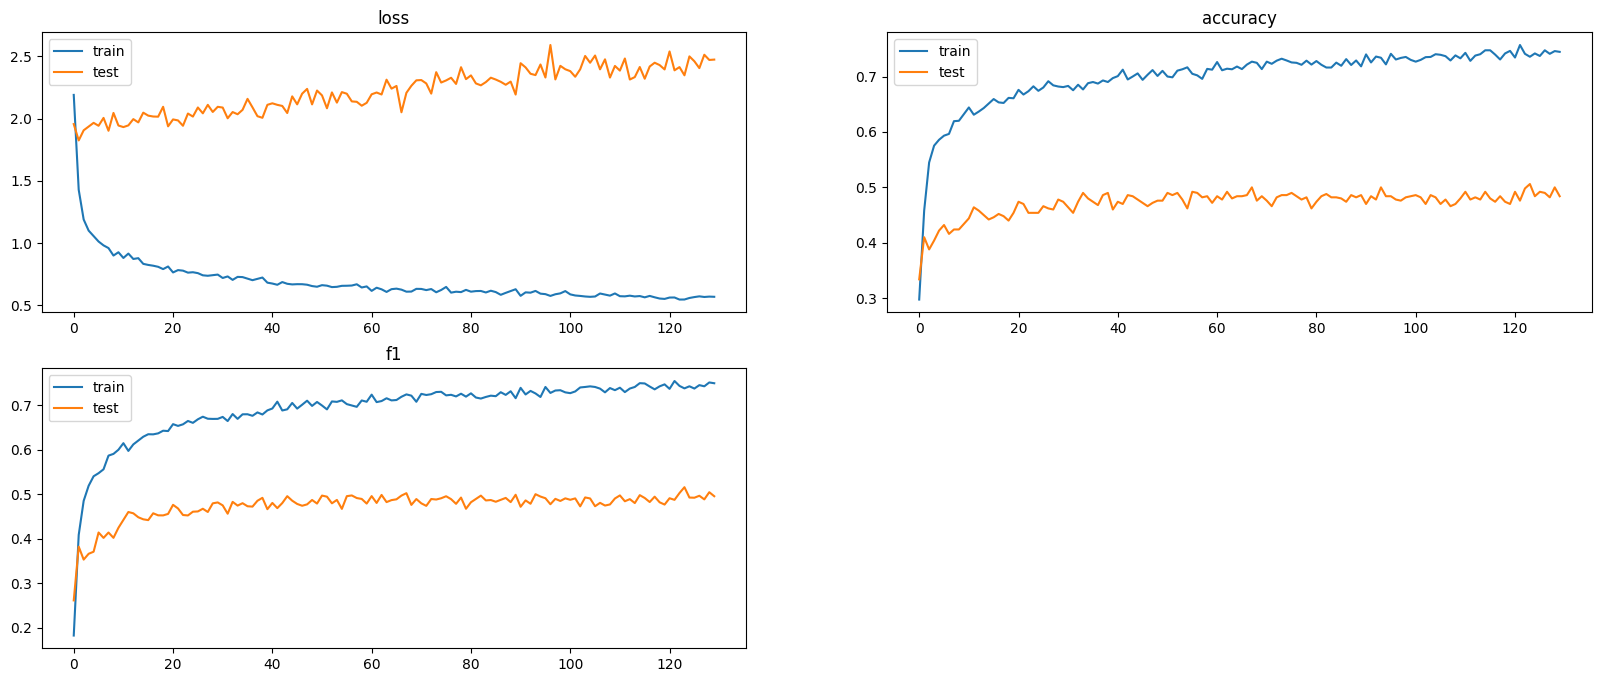

In [48]:
plt.figure(figsize=(20,8))
train_loss_list, train_acc_list, train_f1_list
plt.subplot(2,2,1)
plt.plot(train_loss_list,label='train')
plt.plot(test_loss_list,label='test')
plt.title('loss')
plt.legend()
plt.subplot(2,2,2)
plt.plot(train_acc_list,label='train')
plt.plot(test_acc_list,label='test')
plt.title('accuracy')
plt.legend()
plt.subplot(2,2,3)
plt.plot(train_f1_list,label='train')
plt.plot(test_f1_list,label='test')
plt.title('f1')
plt.legend()
plt.show()

In [49]:
device = torch.device('cuda')
configuration = BertConfig(vocab_size=15000,hidden_size = 64,num_hidden_layers = 3,num_attention_heads = 4,intermediate_size = 512,hidden_dropout_prob=0.2)
BertPreTrainModel = BertForPreTraining(configuration).to(device)
BertPreTrainModel.config.output_hidden_states = True
Bert = CustomBert(BertPreTrainModel).to(device)

num_epochs = 130

optimizer = optim.AdamW(Bert.parameters(),lr=7e-4, weight_decay=0.2)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
scheduler = lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.8)

train_loss_list, train_acc_list, train_f1_list = [], [], []
test_loss_list, test_acc_list, test_f1_list = [], [], []

for epoch in range(num_epochs):
    Bert.train()
    running_loss  = 0.0
    all_prediction , all_lables = [], []
    for i, (tokens_b, labels) in enumerate(finetune_train_loader):
        tokens_b, labels = tokens_b.to(device), labels.to(device)
        batch_size = tokens_b.shape[0]
        token_type_ids = torch.zeros(batch_size,512).to(device=device, dtype=torch.int32)
        token_type_ids[:,256:] = 1
        attention_mask = (tokens_b != 0 ).to(dtype=torch.int32,device=device)
        outputs = Bert(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device))
        predicted = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        all_prediction.append(predicted) , all_lables.append(labels) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    all_prediction_cat = torch.cat(all_prediction).cpu()
    all_lables_cat = torch.cat(all_lables).cpu()
    acc = accuracy_score(all_lables_cat, all_prediction_cat)
    f1 = f1_score(all_lables_cat, all_prediction_cat,average='macro')
    if (epoch + 1) % 10 == 0:
        print(f'epoch {epoch+1} Train loss {running_loss / (i+1):.4f} and accuracy {acc:.3f} f1 {f1:.3f}', end='')
    train_loss_list.append(running_loss / (i+1)), train_acc_list.append(acc), train_f1_list.append(f1)
    
    Bert.eval()
    running_loss  = 0.0
    all_prediction , all_lables = [], []
    with torch.no_grad():
        for i, (tokens_b, labels) in enumerate(finetune_test_loader):
            labels = labels.type(torch.LongTensor) 
            tokens_b, labels = tokens_b.to(device), labels.to(device)
            batch_size = tokens_b.shape[0]
            token_type_ids = torch.zeros(batch_size,512).to(device=device, dtype=torch.int32)
            token_type_ids[:,256:] = 1
            attention_mask = (tokens_b != 0 ).to(dtype=torch.int32,device=device)
            outputs = Bert(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device))
            predicted = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            all_prediction.append(predicted) , all_lables.append(labels) 
            running_loss += loss.item()
    all_prediction_cat = torch.cat(all_prediction).cpu()
    all_lables_cat = torch.cat(all_lables).cpu()
    acc = accuracy_score(all_lables_cat, all_prediction_cat)
    f1 = f1_score(all_lables_cat, all_prediction_cat,average='macro')
    if (epoch + 1) % 10 == 0:
        print(f' -- Test loss {running_loss / (i+1):.4f} and accuracy {acc:.3f} f1 {f1:.3f}')
    test_loss_list.append(running_loss / (i+1)), test_acc_list.append(acc), test_f1_list.append(f1)

epoch 10 Train loss 1.8337 and accuracy 0.360 f1 0.233 -- Test loss 2.0411 and accuracy 0.364 f1 0.175
epoch 20 Train loss 1.6153 and accuracy 0.384 f1 0.282 -- Test loss 2.2480 and accuracy 0.354 f1 0.178
epoch 30 Train loss 1.3895 and accuracy 0.408 f1 0.377 -- Test loss 2.2671 and accuracy 0.364 f1 0.235
epoch 40 Train loss 1.2378 and accuracy 0.488 f1 0.474 -- Test loss 2.4841 and accuracy 0.344 f1 0.268
epoch 50 Train loss 1.0633 and accuracy 0.574 f1 0.575 -- Test loss 2.7342 and accuracy 0.366 f1 0.340
epoch 60 Train loss 0.9149 and accuracy 0.639 f1 0.642 -- Test loss 3.0152 and accuracy 0.402 f1 0.395
epoch 80 Train loss 0.7076 and accuracy 0.716 f1 0.728 -- Test loss 3.4800 and accuracy 0.442 f1 0.409
epoch 90 Train loss 0.6867 and accuracy 0.726 f1 0.733 -- Test loss 3.6816 and accuracy 0.450 f1 0.399
epoch 100 Train loss 0.6183 and accuracy 0.739 f1 0.748 -- Test loss 3.8032 and accuracy 0.442 f1 0.408
epoch 110 Train loss 0.6034 and accuracy 0.757 f1 0.765 -- Test loss 4.1

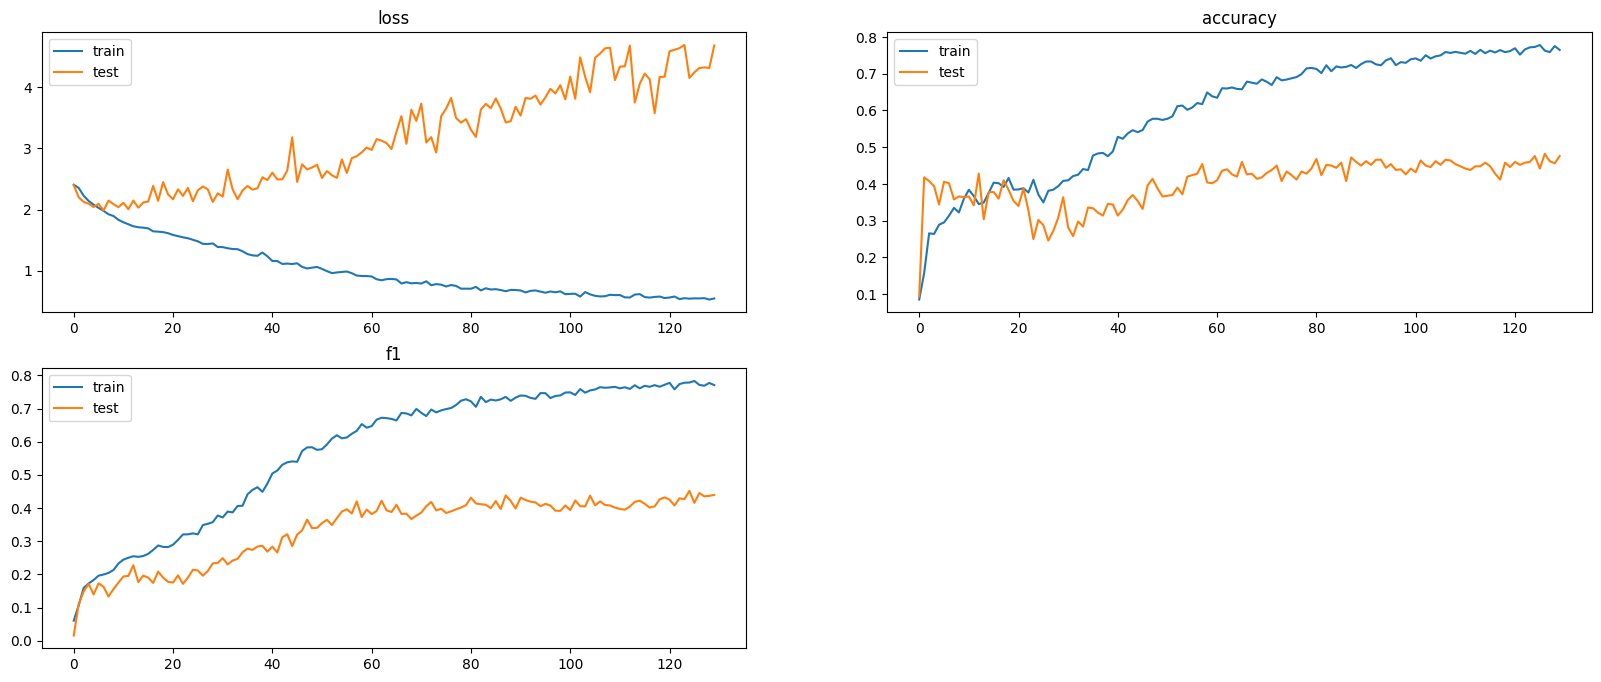

In [50]:
plt.figure(figsize=(20,8))
train_loss_list, train_acc_list, train_f1_list
plt.subplot(2,2,1)
plt.plot(train_loss_list,label='train')
plt.plot(test_loss_list,label='test')
plt.title('loss')
plt.legend()
plt.subplot(2,2,2)
plt.plot(train_acc_list,label='train')
plt.plot(test_acc_list,label='test')
plt.title('accuracy')
plt.legend()
plt.subplot(2,2,3)
plt.plot(train_f1_list,label='train')
plt.plot(test_f1_list,label='test')
plt.title('f1')
plt.legend()
plt.show()

In [11]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
device = torch.device('cuda')
configuration = BertConfig(vocab_size=15000,hidden_size = 256,num_hidden_layers = 6,num_attention_heads = 8,intermediate_size = 1024,hidden_dropout_prob=0.2)
BertPreTrainModel = BertForPreTraining(configuration).to(device)
BertPreTrainModel.config.output_hidden_states = True
Bert = CustomBert(BertPreTrainModel).to(device)

num_epochs = 130

optimizer = optim.AdamW(Bert.parameters(),lr=7e-5, weight_decay=0.2)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
scheduler = lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.8)

train_loss_list, train_acc_list, train_f1_list = [], [], []
test_loss_list, test_acc_list, test_f1_list = [], [], []

for epoch in range(num_epochs):
    Bert.train()
    running_loss  = 0.0
    all_prediction , all_lables = [], []
    for i, (tokens_b, labels) in enumerate(finetune_train_loader):
        tokens_b, labels = tokens_b.to(device), labels.to(device)
        batch_size = tokens_b.shape[0]
        token_type_ids = torch.zeros(batch_size,512).to(device=device, dtype=torch.int32)
        token_type_ids[:,256:] = 1
        attention_mask = (tokens_b != 0 ).to(dtype=torch.int32,device=device)
        outputs = Bert(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device))
        predicted = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        all_prediction.append(predicted) , all_lables.append(labels) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    all_prediction_cat = torch.cat(all_prediction).cpu()
    all_lables_cat = torch.cat(all_lables).cpu()
    acc = accuracy_score(all_lables_cat, all_prediction_cat)
    f1 = f1_score(all_lables_cat, all_prediction_cat,average='macro')
    if (epoch + 1) % 10 == 0:
        print(f'epoch {epoch+1} Train loss {running_loss / (i+1):.4f} and accuracy {acc:.3f} f1 {f1:.3f}', end='')
    train_loss_list.append(running_loss / (i+1)), train_acc_list.append(acc), train_f1_list.append(f1)
    
    Bert.eval()
    running_loss  = 0.0
    all_prediction , all_lables = [], []
    with torch.no_grad():
        for i, (tokens_b, labels) in enumerate(finetune_test_loader):
            labels = labels.type(torch.LongTensor) 
            tokens_b, labels = tokens_b.to(device), labels.to(device)
            batch_size = tokens_b.shape[0]
            token_type_ids = torch.zeros(batch_size,512).to(device=device, dtype=torch.int32)
            token_type_ids[:,256:] = 1
            attention_mask = (tokens_b != 0 ).to(dtype=torch.int32,device=device)
            outputs = Bert(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device))
            predicted = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            all_prediction.append(predicted) , all_lables.append(labels) 
            running_loss += loss.item()
    all_prediction_cat = torch.cat(all_prediction).cpu()
    all_lables_cat = torch.cat(all_lables).cpu()
    acc = accuracy_score(all_lables_cat, all_prediction_cat)
    f1 = f1_score(all_lables_cat, all_prediction_cat,average='macro')
    if (epoch + 1) % 10 == 0:
        print(f' -- Test loss {running_loss / (i+1):.4f} and accuracy {acc:.3f} f1 {f1:.3f}')
    test_loss_list.append(running_loss / (i+1)), test_acc_list.append(acc), test_f1_list.append(f1)

epoch 10 Train loss 2.0371 and accuracy 0.241 f1 0.190 -- Test loss 1.9610 and accuracy 0.322 f1 0.163
epoch 20 Train loss 1.4268 and accuracy 0.457 f1 0.455 -- Test loss 1.4351 and accuracy 0.494 f1 0.519
epoch 30 Train loss 1.0341 and accuracy 0.610 f1 0.598 -- Test loss 1.3291 and accuracy 0.562 f1 0.566
epoch 40 Train loss 0.8612 and accuracy 0.675 f1 0.665 -- Test loss 1.5380 and accuracy 0.556 f1 0.549
epoch 50 Train loss 0.7616 and accuracy 0.707 f1 0.707 -- Test loss 1.6278 and accuracy 0.568 f1 0.577
epoch 60 Train loss 0.6772 and accuracy 0.738 f1 0.739 -- Test loss 1.9021 and accuracy 0.568 f1 0.564
epoch 70 Train loss 0.6370 and accuracy 0.752 f1 0.749 -- Test loss 1.9830 and accuracy 0.572 f1 0.577


In [63]:
class CustomBert2(nn.Module):
    def __init__(self, BertPreTrainModel):
        super(CustomBert2, self).__init__()
        self.BertPreTrainModel = BertPreTrainModel
        self.fc = nn.Sequential(
            nn.Linear(BertPreTrainModel.config.hidden_size,412),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(412,128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(128,11)
        )
        
    def forward(self,input_ids,attention_mask,token_type_ids,position_ids):
        out = self.BertPreTrainModel(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=position_ids)
        cls_state = out.hidden_states[-1][:,0,:] # batch, 512, 768 select CLS
        return self.fc(cls_state)

In [65]:
device = torch.device('cuda')
BertPreTrainModel = BertForPreTraining.from_pretrained('google-bert/bert-base-uncased')
BertPreTrainModel.config.output_hidden_states = True
Bert = CustomBert2(BertPreTrainModel).to(device)

num_epochs = 5

optimizer = optim.AdamW([
    {'params': Bert.BertPreTrainModel.parameters(), 'lr': 2e-5, 'weight_decay':0.2}, 
    {'params': Bert.fc.parameters(), 'lr': 4e-3, 'weight_decay':0.2}])
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
scheduler = lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.8)

train_loss_list, train_acc_list, train_f1_list = [], [], []
test_loss_list, test_acc_list, test_f1_list = [], [], []

for epoch in range(num_epochs):
    Bert.train()
    running_loss  = 0.0
    all_prediction , all_lables = [], []
    for i, (tokens_b, labels) in enumerate(finetune_train_loader):
        tokens_b, labels = tokens_b.to(device), labels.to(device)
        batch_size = tokens_b.shape[0]
        token_type_ids = torch.zeros(batch_size,512).to(device=device, dtype=torch.int32)
        token_type_ids[:,256:] = 1
        attention_mask = (tokens_b != 0 ).to(dtype=torch.int32,device=device)
        outputs = Bert(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device))
        predicted = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        all_prediction.append(predicted) , all_lables.append(labels) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    all_prediction_cat = torch.cat(all_prediction).cpu()
    all_lables_cat = torch.cat(all_lables).cpu()
    acc = accuracy_score(all_lables_cat, all_prediction_cat)
    f1 = f1_score(all_lables_cat, all_prediction_cat,average='macro')
    print(f'epoch {epoch+1} Train loss {running_loss / (i+1):.4f} and accuracy {acc:.3f} f1 {f1:.3f}', end='')
    train_loss_list.append(running_loss / (i+1)), train_acc_list.append(acc), train_f1_list.append(f1)
    
    Bert.eval()
    running_loss  = 0.0
    all_prediction , all_lables = [], []
    with torch.no_grad():
        for i, (tokens_b, labels) in enumerate(finetune_test_loader):
            labels = labels.type(torch.LongTensor) 
            tokens_b, labels = tokens_b.to(device), labels.to(device)
            batch_size = tokens_b.shape[0]
            token_type_ids = torch.zeros(batch_size,512).to(device=device, dtype=torch.int32)
            token_type_ids[:,256:] = 1
            attention_mask = (tokens_b != 0 ).to(dtype=torch.int32,device=device)
            outputs = Bert(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device))
            predicted = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, labels)
            all_prediction.append(predicted) , all_lables.append(labels) 
            running_loss += loss.item()
    all_prediction_cat = torch.cat(all_prediction).cpu()
    all_lables_cat = torch.cat(all_lables).cpu()
    acc = accuracy_score(all_lables_cat, all_prediction_cat)
    f1 = f1_score(all_lables_cat, all_prediction_cat,average='macro')
    print(f' -- Test loss {running_loss / (i+1):.4f} and accuracy {acc:.3f} f1 {f1:.3f}')
    test_loss_list.append(running_loss / (i+1)), test_acc_list.append(acc), test_f1_list.append(f1)

epoch 1 Train loss 2.4194 and accuracy 0.117 f1 0.074 -- Test loss 2.4013 and accuracy 0.284 f1 0.040


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,8))
train_loss_list, train_acc_list, train_f1_list
plt.subplot(2,2,1)
plt.plot(train_loss_list,label='train')
plt.plot(test_loss_list,label='test')
plt.title('loss')
plt.legend()
plt.subplot(2,2,2)
plt.plot(train_acc_list,label='train')
plt.plot(test_acc_list,label='test')
plt.title('accuracy')
plt.legend()
plt.subplot(2,2,3)
plt.plot(train_f1_list,label='train')
plt.plot(test_f1_list,label='test')
plt.title('f1')
plt.legend()
plt.show()

In [45]:
def evaluate():
    lables_list, pred_list = [] , []
    with torch.no_grad():
        for i, (tokens_b, labels) in enumerate(train_loader):
            labels = labels.type(torch.LongTensor) 
            tokens_b, labels = tokens_b.to(device), labels.to(device)
            batch_size = tokens_b.shape[0]
            token_type_ids = torch.zeros(batch_size,512).to(device=device, dtype=torch.int32)
            token_type_ids[:,256:] = 1
            attention_mask = (tokens_b != 0 ).to(dtype=torch.int32,device=device)
            outputs = Bert(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device))
            predicted = torch.argmax(outputs, dim=1)
            lables_list.append(labels.cpu()), pred_list.append(predicted.cpu())

    all_labels = torch.cat(lables_list)
    all_pred = torch.cat(pred_list)
    print('train')
    print(f' accuracy : {accuracy_score(all_labels, all_pred)}')
    print(' precision : ' , precision_score(all_labels, all_pred,average='macro'))
    print(' recall : ',  recall_score(all_labels, all_pred,average='macro'))
    print(' f1-score : ', f1_score(all_labels, all_pred,average='macro'))
    
    lables_list, pred_list = [] , []
    with torch.no_grad():
        for i, (tokens_b, labels) in enumerate(test_loader):
            labels = labels.type(torch.LongTensor) 
            tokens_b, labels = tokens_b.to(device), labels.to(device)
            batch_size = tokens_b.shape[0]
            token_type_ids = torch.zeros(batch_size,512).to(device=device, dtype=torch.int32)
            token_type_ids[:,256:] = 1
            attention_mask = (tokens_b != 0 ).to(dtype=torch.int32,device=device)
            outputs = Bert(input_ids=tokens_b,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=torch.arange(512).to(device))
            predicted = torch.argmax(outputs, dim=1)
            lables_list.append(labels.cpu()), pred_list.append(predicted.cpu())

    all_labels = torch.cat(lables_list)
    all_pred = torch.cat(pred_list)
    print('test')
    print(f' accuracy : {accuracy_score(all_labels, all_pred)}')
    print(' precision : ' , precision_score(all_labels, all_pred,average='macro'))
    print(' recall : ',  recall_score(all_labels, all_pred,average='macro'))
    print(' f1-score : ', f1_score(all_labels, all_pred,average='macro'))
evaluate()

train
 accuracy : 0.6894160583941605
 precision :  0.6944111905517566
 recall :  0.756283559402048
 f1-score :  0.6982829377595388
test
 accuracy : 0.6299270072992701
 precision :  0.6511270499538159
 recall :  0.6811161490337301
 f1-score :  0.6402402149638239
